In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [3]:
file_path = '../Features/Large/selected_features_CorrVar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,RingCount,MolLogP,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_ether,fr_halogen
0,0,0.545511,0.223433,0.490223,0.390551,0.291325,0.250000,0.472316,0.592036,-1.017995,...,0.447214,0.451534,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
1,1,0.591920,0.253125,0.601726,0.389406,0.277681,0.278846,0.315886,0.215424,1.052267,...,0.447214,0.416318,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
2,1,0.553126,0.334919,0.502072,0.400859,0.399452,0.278846,0.472195,0.592036,-1.018511,...,0.447214,0.475805,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
3,0,0.612445,0.602032,0.496240,0.408749,0.461148,0.423077,0.676377,0.290413,0.491735,...,0.000000,0.560347,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
4,0,0.618170,0.914475,0.141109,0.000000,0.000000,0.000000,0.354992,0.378416,-0.071536,...,0.000000,0.225586,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [4]:
feature_names = list(df.columns)
feature_names

['Irritation',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'SPS',
 'MolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'FpDensityMorgan1',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'SlogP_VSA8',
 'TPSA',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',

In [63]:
with open('feature_names.txt', 'w') as f:
    for line in feature_names:
        f.write(f"{line}\n")

In [6]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [7]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Now, split training data into training (80%) and validation (20%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 1796 samples
Validation set: 317 samples
Test set: 374 samples


In [8]:

def objective(trial):
    # Define hyperparameter search space
    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "dart",
        "lambda": trial.suggest_float("lambda", 1e-2, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-2, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 5, 100),  
    }

    # Set up cross-validation with StratifiedKFold
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    accuracy_scores = []
    log_loss_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]  
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**param, use_label_encoder=False)
        model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_valid_cv, y_valid_cv)],  # Validation data for early stopping
            verbose=False
        )

        # Check if early stopping kicked in and model is valid
        if model.best_iteration is None:
            return float("inf")  # Ensure that the trial doesn't return None, this avoids invalid models

        # Predict on validation set
        y_pred_cv = model.predict(X_valid_cv)
        y_pred_proba = model.predict_proba(X_valid_cv)[:, 1]  # Probabilities for log loss

        accuracy_scores.append(accuracy_score(y_valid_cv, y_pred_cv))
        log_loss_scores.append(log_loss(y_valid_cv, y_pred_proba))

    # Use the mean accuracy or log loss across folds as the objective
    mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    mean_log_loss = sum(log_loss_scores) / len(log_loss_scores)

    return mean_log_loss  # You can use accuracy or log_loss depending on which is more important


# Run Optuna optimization
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
final_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-03-09 16:05:11,907] A new study created in memory with name: no-name-cb4036d3-0abf-459e-9f33-529815783eb1
[W 2025-03-09 16:05:18,857] Trial 0 failed with parameters: {'lambda': 6.229632999853556, 'alpha': 0.41328523240273646, 'learning_rate': 0.15282547429983961, 'n_estimators': 484, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.0389871860975263e-05, 'subsample': 0.7213572433249188, 'colsample_bytree': 0.612186792660351, 'early_stopping_rounds': 96} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/monika/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/n4/lx5wz8kj2r79g9p8wxdnqk580000gn/T/ipykernel_44574/2984421052.py", line 29, in objective
    model.fit(
  File "/Users/monika/Library/Python/3.9/lib/python/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/monika/Library/Python/

KeyboardInterrupt: 

In [9]:
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

def objective(trial):
    # Define hyperparameter search space
    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",  # Try gbtree for general tasks
        "lambda": trial.suggest_float("lambda", 1e-2, 5.0, log=True),  # Slightly decrease regularization
        "alpha": trial.suggest_float("alpha", 1e-2, 5.0, log=True),  # Slightly decrease regularization
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),  # Increase if necessary
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),  # Increase number of trees
        "max_depth": trial.suggest_int("max_depth", 3, 6),  # Try lower max_depth (3-6)
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 15),  # Increase slightly to control splits
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),  # Increase subsample for more randomness
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9),  # Increase for randomness
        "random_state": 42
    }



    # Cross-validation setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_log_losses, valid_log_losses = [], []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]  
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**param, use_label_encoder=False, early_stopping_rounds=50)
        model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_valid_cv, y_valid_cv)],  # Move this out of Optuna tuning
            verbose=False
        )

        # Predictions
        y_train_pred_proba = model.predict_proba(X_train_cv)[:, 1]
        y_valid_pred_proba = model.predict_proba(X_valid_cv)[:, 1]

        # Store training and validation log loss
        train_log_losses.append(log_loss(y_train_cv, y_train_pred_proba))
        valid_log_losses.append(log_loss(y_valid_cv, y_valid_pred_proba))

    # Compute the log loss gap to minimize overfitting
    mean_train_loss = sum(train_log_losses) / len(train_log_losses)
    mean_valid_loss = sum(valid_log_losses) / len(valid_log_losses)
    overfit_gap = abs(mean_train_loss - mean_valid_loss)

    return overfit_gap  # Minimize the gap to reduce overfitting

# Run Optuna optimization
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
final_model = xgb.XGBClassifier(**best_params, early_stopping_rounds=50,  use_label_encoder=False)
final_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-03-09 16:05:21,331] A new study created in memory with name: no-name-b311b753-0525-4ca3-8cae-39e7e56e1a1a


[I 2025-03-09 16:05:24,826] Trial 0 finished with value: 0.16562823001094862 and parameters: {'lambda': 0.2644873904255651, 'alpha': 1.4090082595319917, 'learning_rate': 0.034823225728318, 'n_estimators': 126, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.0027221137235630116, 'subsample': 0.8849686045605781, 'colsample_bytree': 0.8651968417709285}. Best is trial 0 with value: 0.16562823001094862.
[I 2025-03-09 16:05:32,122] Trial 1 finished with value: 0.13612962684655222 and parameters: {'lambda': 1.9265020615106403, 'alpha': 1.9439407366777601, 'learning_rate': 0.01574897126844499, 'n_estimators': 300, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.0022266343132230477, 'subsample': 0.8772678461559662, 'colsample_bytree': 0.7292728411954614}. Best is trial 1 with value: 0.13612962684655222.
[I 2025-03-09 16:05:37,324] Trial 2 finished with value: 0.14894554217906164 and parameters: {'lambda': 1.051849204740703, 'alpha': 0.8280214133029556, 'learning_rate': 0.029531564660978355,

Best trial: {'lambda': 0.24644689387153704, 'alpha': 1.2732379224892134, 'learning_rate': 0.012004564457597518, 'n_estimators': 111, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 0.016366043335389848, 'subsample': 0.8600790945678106, 'colsample_bytree': 0.7277484674390412}
[0]	validation_0-logloss:0.69027
[1]	validation_0-logloss:0.68792
[2]	validation_0-logloss:0.68543
[3]	validation_0-logloss:0.68307
[4]	validation_0-logloss:0.68071
[5]	validation_0-logloss:0.67823
[6]	validation_0-logloss:0.67615
[7]	validation_0-logloss:0.67416
[8]	validation_0-logloss:0.67193
[9]	validation_0-logloss:0.66970
[10]	validation_0-logloss:0.66756
[11]	validation_0-logloss:0.66570
[12]	validation_0-logloss:0.66385
[13]	validation_0-logloss:0.66188
[14]	validation_0-logloss:0.66021
[15]	validation_0-logloss:0.65826
[16]	validation_0-logloss:0.65625
[17]	validation_0-logloss:0.65452
[18]	validation_0-logloss:0.65287
[19]	validation_0-logloss:0.65105
[20]	validation_0-logloss:0.64935
[21]	validation_0-l

In [41]:
# Define the objective function for Optuna with cross-validation
def objective(trial):
    # Define the hyperparameter space
    params = {
        'objective': 'binary:logistic',  # Change this if using a different task
        'eval_metric': 'logloss',       # Metric for evaluation
        'use_label_encoder': False,     # Disable XGBoost warning
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }

    # Create an XGBoost classifier with the suggested parameters
    model = xgb.XGBClassifier(**params)

    # Perform cross-validation and return the average accuracy across the folds
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    return score.mean()

# Create a study and optimize it
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy on Test Set:", final_accuracy)

[I 2025-03-07 12:25:56,879] A new study created in memory with name: no-name-9056792b-5956-4ed0-8053-17e68f90d035
[I 2025-03-07 12:25:57,124] Trial 0 finished with value: 0.7578180129990716 and parameters: {'max_depth': 4, 'learning_rate': 0.1411670958613902, 'n_estimators': 74, 'min_child_weight': 10, 'gamma': 0.9603579655288287, 'subsample': 0.6878944553995621, 'colsample_bytree': 0.8918767819176487, 'lambda': 0.18107048406543425, 'alpha': 0.9172473503536686}. Best is trial 0 with value: 0.7578180129990716.
[I 2025-03-07 12:25:58,031] Trial 1 finished with value: 0.7533488084184464 and parameters: {'max_depth': 7, 'learning_rate': 0.032227479996268064, 'n_estimators': 134, 'min_child_weight': 1, 'gamma': 0.6980221301108485, 'subsample': 0.5853641488227034, 'colsample_bytree': 0.8663817236967843, 'lambda': 0.005235180021490302, 'alpha': 1.179767989238929}. Best is trial 0 with value: 0.7578180129990716.
[I 2025-03-07 12:25:59,266] Trial 2 finished with value: 0.7533395233673785 and pa

Best parameters: {'max_depth': 4, 'learning_rate': 0.1411670958613902, 'n_estimators': 74, 'min_child_weight': 10, 'gamma': 0.9603579655288287, 'subsample': 0.6878944553995621, 'colsample_bytree': 0.8918767819176487, 'lambda': 0.18107048406543425, 'alpha': 0.9172473503536686}
Best score: 0.7578180129990716
Final Accuracy on Test Set: 0.713903743315508


In [33]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve, validation_curve

Final Model Accuracy on Test: 0.7272727272727273
Available results keys: dict_keys(['validation_0', 'validation_1'])


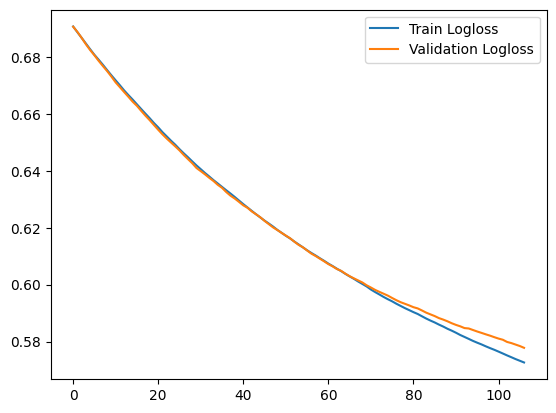

[0]	validation_0-logloss:0.69241
[1]	validation_0-logloss:0.69049
[2]	validation_0-logloss:0.68905
[3]	validation_0-logloss:0.68703
[4]	validation_0-logloss:0.68542
[5]	validation_0-logloss:0.68376
[6]	validation_0-logloss:0.68146
[7]	validation_0-logloss:0.67956
[8]	validation_0-logloss:0.67766
[9]	validation_0-logloss:0.67583
[10]	validation_0-logloss:0.67358
[11]	validation_0-logloss:0.67187
[12]	validation_0-logloss:0.67021
[13]	validation_0-logloss:0.66876
[14]	validation_0-logloss:0.66784
[15]	validation_0-logloss:0.66615
[16]	validation_0-logloss:0.66459
[17]	validation_0-logloss:0.66281
[18]	validation_0-logloss:0.66114
[19]	validation_0-logloss:0.65969
[20]	validation_0-logloss:0.65789
[21]	validation_0-logloss:0.65634
[22]	validation_0-logloss:0.65468
[23]	validation_0-logloss:0.65313
[24]	validation_0-logloss:0.65168
[25]	validation_0-logloss:0.64987
[26]	validation_0-logloss:0.64846
[27]	validation_0-logloss:0.64699
[28]	validation_0-logloss:0.64530
[29]	validation_0-loglos

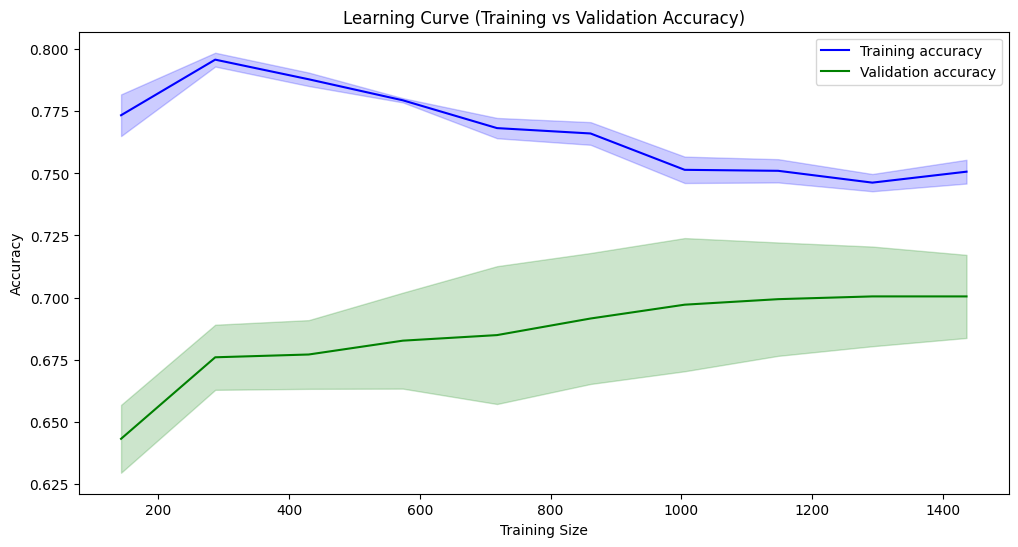

Train Accuracy: 0.7433184855233853
Test Accuracy: 0.7272727272727273


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot

# Get best hyperparameters from study
best_params = study.best_trial.params
# best_params = {'booster': 'dart', 'lambda': 6.109101796965115, 'alpha': 2.1542301910444617, 'learning_rate': 0.15828508410665312, 'n_estimators': 200, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0015829960103862651, 'subsample': 0.6335396537951385, 'colsample_bytree': 0.562796436427881, 'early_stopping_rounds': 45}

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate final model
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# Get the evaluation results from the training process
results = final_model.evals_result()

# Print the available keys in results to help diagnose the issue
print("Available results keys:", results.keys())

# Check if 'validation_1' exists in the results
if 'validation_1' in results:
    # Plot learning curves for training and validation
    pyplot.plot(results['validation_0']['logloss'], label='Train Logloss')
    pyplot.plot(results['validation_1']['logloss'], label='Validation Logloss')
else:
    print("Validation set logloss not found in the results")

# Show the legend and plot
pyplot.legend()
pyplot.show()

# Learning Curves with Early Stopping
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10),
    fit_params={'eval_set': [(X_valid, y_valid)]}  # Still using validation set for this step
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# AUC-ROC Plot
# Get predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [9]:
Best_trial: {'booster': 'gbtree', 'lambda': 0.0052103621382832265, 'alpha': 0.1620577811386946, 'learning_rate': 0.1170210607506638, 'n_estimators': 327, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 1.6589810670976416e-05, 'subsample': 0.7843052779851918, 'colsample_bytree': 0.5079409289423329}


In [ ]:
Best_trial: {'booster': 'dart', 'lambda': 0.020998703887689537, 'alpha': 0.1390447886551301, 'learning_rate': 0.11229332078448975, 'n_estimators': 559, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 2.0219692829063354e-05, 'subsample': 0.7175177317110472, 'colsample_bytree': 0.8899318411369608}


In [ ]:
Best_trial: {'booster': 'dart', 'lambda': 3.9815594987137994, 'alpha': 1.1692306809315036, 'learning_rate': 0.08046698602150275, 'n_estimators': 700, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.123245273357147e-05, 'subsample': 0.7970691270411416, 'colsample_bytree': 0.6813800155627162}

In [ ]:
Best_trial: {'booster': 'dart', 'lambda': 0.09103305658827118, 'alpha': 0.22251956198876638, 'learning_rate': 0.08161540222283686, 'n_estimators': 559, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.0053773276652879475, 'subsample': 0.5030121659898422, 'colsample_bytree': 0.6694670222318585, 'early_stopping_rounds': 67}


In [ ]:
Best_trial: {'booster': 'dart', 'lambda': 0.08177521234352274, 'alpha': 0.00023649167150269546, 'learning_rate': 0.1293122083586557, 'n_estimators': 576, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.00046343198602445494, 'subsample': 0.693642295185491, 'colsample_bytree': 0.7782649518684708, 'early_stopping_rounds': 61}


In [60]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'qsar_model.pkl')

print("Model saved successfully!")


Model saved successfully!
